# Reto Evaluación y Refinamiento de modelo

En este proyecto, se propone crear un modelo de clasificación utilizando el algoritmo Random Forest. Para llevar a cabo este proceso, optamos por utilizar Python como lenguaje de programación y el framework de sklearn, ya que es conocido por su facilidad de uso y una amplia gama de bibliotecas disponibles para la manipulación y análisis de datos.

Se utilizara el dataset de **Titanic** donde, **se predece si una persona sobrevivió o no al desastre del Titanic**. Para conocer más sobre este proyecto se puede consultar el siguiente link: https://www.kaggle.com/competitions/titanic

El proceso estara documentado con comentarios en el codigo, y mostrara paso a paso el desarrollo del modelo con el uso del framework.

Para mas informacion de este proyecto, utiliza la liga del repositorio: https://github.com/lordschipper5/TC3006C.101-Portafolio-A01720253.git

Para este proceso se utilizaran archivos que fueron modificados con el proceso de ETL, este proceso se puede encontrar en: https://github.com/ArturoGarzaTec/TC3006C.101_Equipo.git

Los archivos que estaremos utilizando del ETL son **train_data y test_data**.

Ambos archivos se encuentran aqui:

https://drive.google.com/file/d/1T_ZRV0zAYqC3d1am8xCXJ6CqDRyptBw0/view?usp=sharing

https://drive.google.com/file/d/1gJDScqXANL15oZilDhXhkL_fxIa-Jrjh/view?usp=sharing



## Importar módulos

In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler # Funcion para escalar datos
import graphviz
from sklearn.tree import export_graphviz
from google.colab import drive

## Cargar datos

In [ ]:
drive.mount('/content/drive')

# Cargar los archivos de datos
train_df = pd.read_csv('/content/drive/MyDrive/TC3006C.101_OpenAIGPT/Reto/Datos/Evidencia01/train_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/TC3006C.101_OpenAIGPT/Reto/Datos/Evidencia01/test_data.csv')

test_df.head()

Mounted at /content/drive


,Pclass,Age,Sex,Fam,Fare,Embarked
0,3,22,1,1,0,2
1,1,38,0,1,3,1
2,3,26,0,0,1,2
3,1,35,0,1,3,2
4,3,35,1,0,1,2


## Separación de datos en subconjuntos

Para entrenar al modelo se dividen los datos en los subconjuntos de entrenamiento, vaidación y prueba en una proporción de sesenta, veinte y veinte respectivamente. Para realizar este división se utiliza la función **train_test_split**, la cual selecciona las muestras para cada subconjunto aleatoriamente.

Además, con el propósito de evitar un sesgo en el modelo se **escalan** los datos de los subconjuntos de entrenamiento, validación y prueba. Para esto se utiliza el módulo de **preprocesamiento de sklearn**.

In [ ]:
# Separar la columna 'Survived' para el conjunto de entrenamiento
n = len(train_df.columns) - 1
X = train_df.iloc[:, 0:n]
y = train_df.iloc[:, n]

# Dividir el dataset en conjuntos de entrenamiento (60%), validación (20%) y prueba (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Escalamiento de datos por subconjunto
# sc_X = StandardScaler()
# X_train = sc_X.fit_transform(X_train)
# X_test = sc_X.transform(X_test)
# X_val = sc_X.transform(X_val)


## Entrenamiento del modelo

In [ ]:
# Crear el modelo Random Forest
modeloRandomForest = RandomForestClassifier(criterion='entropy',random_state=42)

# Definir los parámetros a probar para encontrar una mejor configuración (Usar valores chicos para evitar overfitting)
param_grid = {
    'n_estimators': [100, 200],  # Cantidad de árboles
    'max_depth': [5, 10, 12, 15],  # Profundidad de árbol
    'min_samples_split': [5, 10, 12, 15],  # Cantidad mínima de muestras para dividir un nodo
}

# Realizar una búsqueda de hiperparámetros con GridSearch de sklearn
grid_search = GridSearchCV(modeloRandomForest, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Obtener los mejores parámetros
params_optimo = grid_search.best_params_
print("Mejores parámetros:", params_optimo)


# Entrenar el modelo con los mejores parámetros obtenidos en el conjunto de entrenamiento
modeloRandomForestConf = RandomForestClassifier(criterion='entropy',
                                                n_estimators=params_optimo['n_estimators'],
                                                max_depth=params_optimo['max_depth'],
                                                min_samples_split=params_optimo['min_samples_split'],
                                                random_state=42)
modeloRandomForestConf.fit(X_train, y_train)

Mejores parámetros: {'max_depth': 15, 'min_samples_split': 15, 'n_estimators': 100}


RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_split=15,
                       random_state=42)

## Análisis de desempeño

### Curva aprendizaje

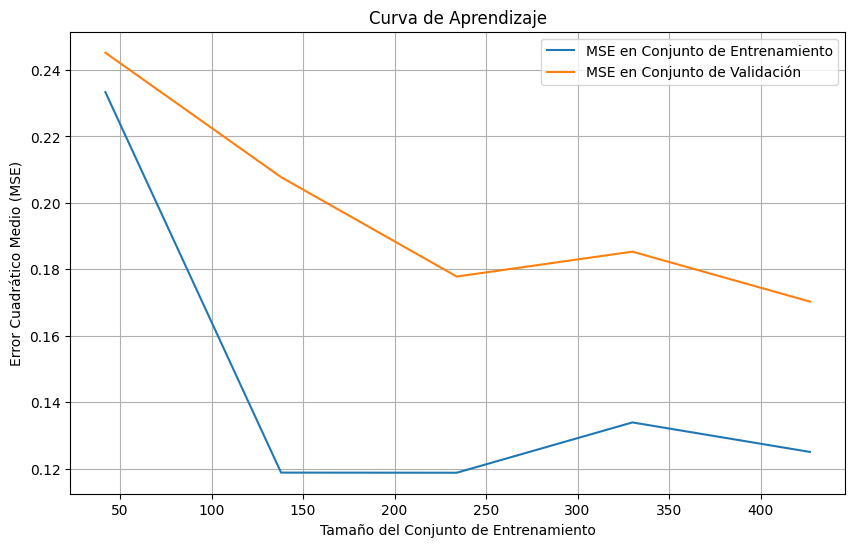

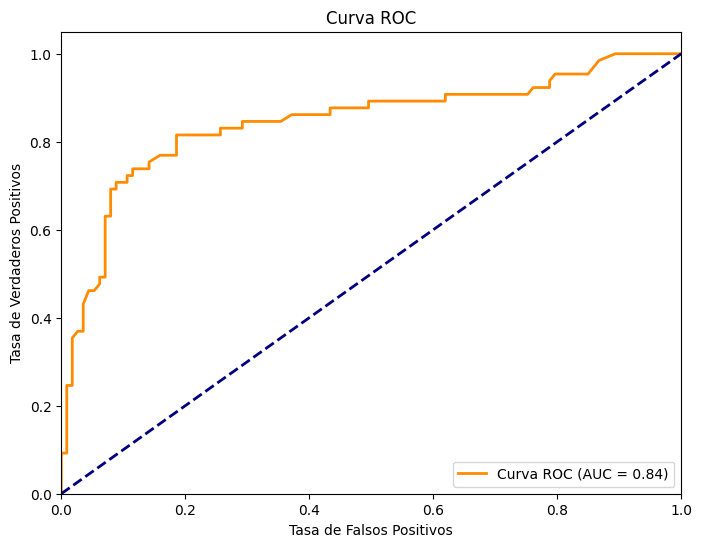

In [ ]:
# Visualizar la curva de aprendizaje (learning curve)
# Calcular el error cuadrático medio (MSE) en el conjunto de entrenamiento y validación
train_sizes, train_errors, val_errors = learning_curve(
    modeloRandomForestConf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convertir el error a positivo y tomar la media
train_errors = -np.mean(train_errors, axis=1)
val_errors = -np.mean(val_errors, axis=1)

# Visualizar la curva de aprendizaje del MSE
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_errors, label='MSE en Conjunto de Entrenamiento')
plt.plot(train_sizes, val_errors, label='MSE en Conjunto de Validación')
plt.xlabel('Tamaño del Conjunto de Entrenamiento')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('Curva de Aprendizaje')
plt.legend()
plt.grid()
plt.show()

# Calcular y visualizar las curvas ROC en el conjunto de validación
y_val_prob = modeloRandomForestConf.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

### Resultados del subconjunto de prueba

Métricas en el conjunto de prueba:
Accuracy score: 0.8100558659217877
Precision score: 0.875
Recall score: 0.6447368421052632
F1 score: 0.7424242424242424


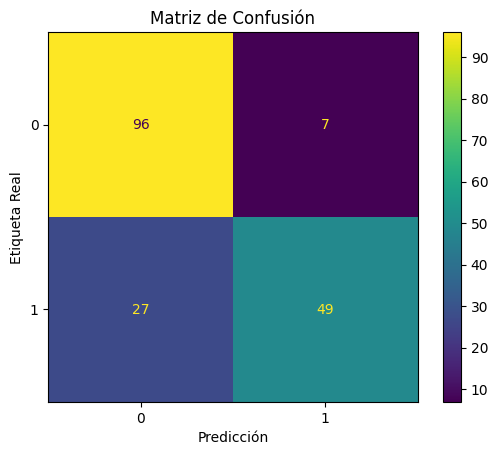

'decision_tree.pdf'

In [ ]:
# Predecir los valores en el conjunto de prueba
y_pred = modeloRandomForestConf.predict(X_test)

# Calcular las métricas
print("Métricas en el conjunto de prueba:")
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("Precision score:", precision_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como una imagen
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción')
plt.show()

# Visualizar un árbol del random forest
estimator = modeloRandomForestConf.estimators_[0]  # Seleccionar el primer árbol
myTreeData = export_graphviz(estimator, out_file=None,
                            feature_names= X_test.columns,
                            class_names=['Not Survived', 'Survived'],
                            filled=True, rounded=True, special_characters=True)

graphData = graphviz.Source(myTreeData)
graphData.view(filename='decision_tree')

### Predicciones puntuales

In [ ]:
# Crear un DataFrame con datos de ejemplo
nuevos_datos_manual = pd.DataFrame({
    'Pclass': [1],
    'Sex': [0],
    'Age': [36],
    'Fam': [3],
    'Fare': [3],
    'Embarked': [1]
})

# Asegurarse de que las columnas estén en el mismo orden que en el conjunto de entrenamiento
columnas_orden = X.columns  # Obtener las columnas en el mismo orden
nuevos_datos_manual = nuevos_datos_manual[columnas_orden]

# Utilizar el modelo ya entrenado para predecir los resultados para los nuevos datos ingresados manualmente
resultados_predichos_manual = modeloRandomForestConf.predict(nuevos_datos_manual)

# Imprimir los resultados de la prediccion
for resultado in resultados_predichos_manual:
    if resultado == 0:
        print("No sobrevivió")
    else:
        print("Sobrevivió")

Sobrevivió
